In [14]:
%matplotlib inline
import math
import random

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_boston

import numpy as np
import tensorflow as tf

sns.set(style="ticks", color_codes=True)

In [15]:
#load data from scikit-learn library
dataset = load_boston()

#load data as DataFrame
houses = pd.DataFrame(dataset.data, columns=dataset.feature_names)
#add target data to DataFrame
houses['target'] = dataset.target

#print first 5 entries of data
print houses.head()

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  target  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2  


In [16]:
print dataset['DESCR']

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

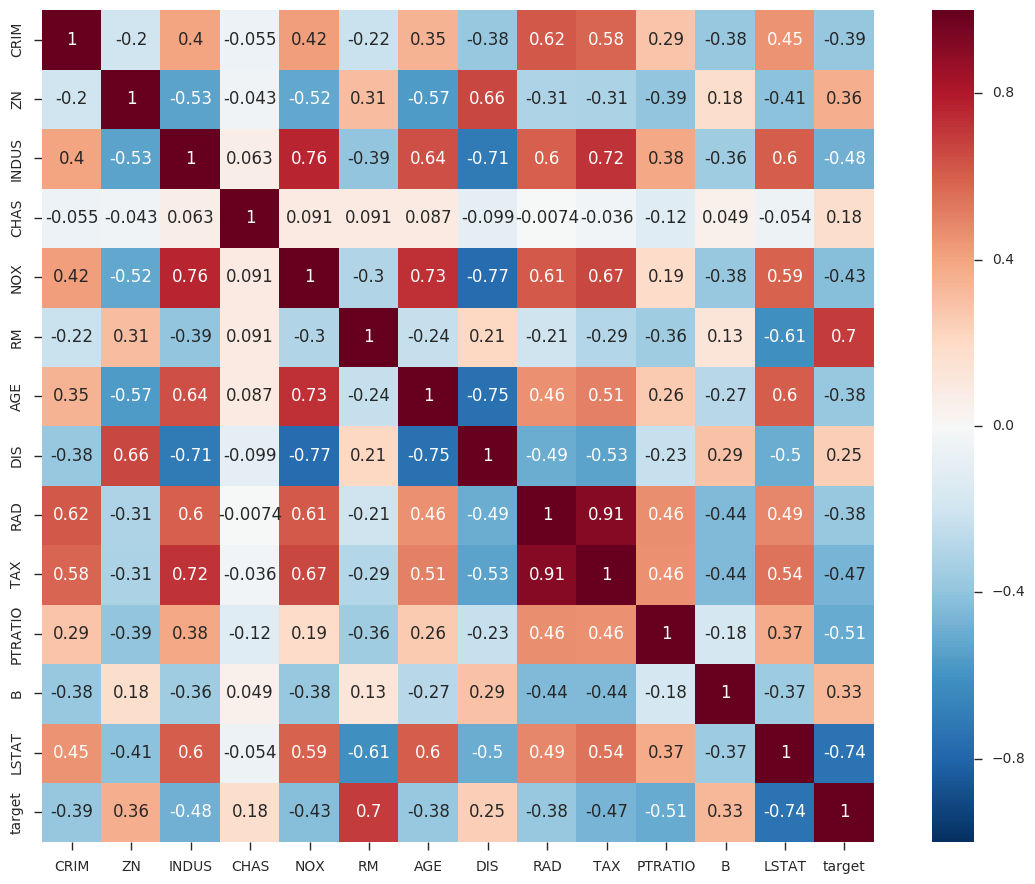

In [17]:
# Load the datset of correlations between cortical brain networks
corrmat = houses.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, annot=True, square=True)

# sns.heatmap(flights, annot=True, fmt="d", linewidths=.5)

f.tight_layout()

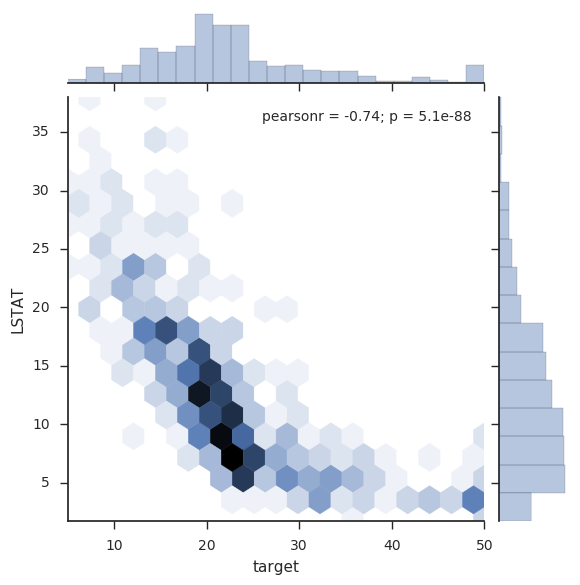

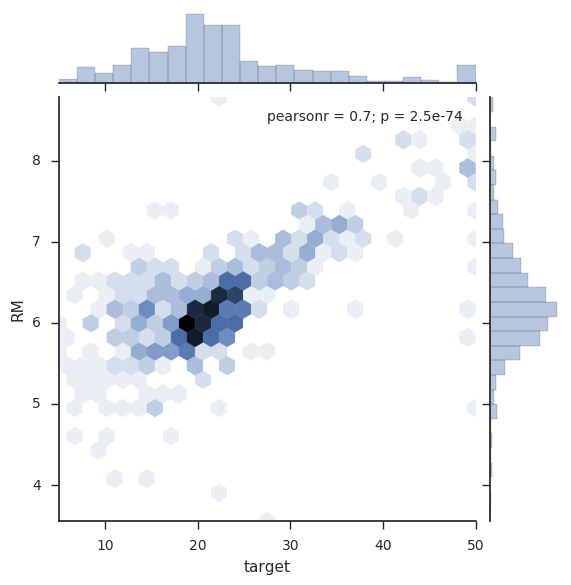

In [18]:
sns.jointplot(houses['target'], houses['LSTAT'], kind='hex')
sns.jointplot(houses['target'], houses['RM'], kind='hex')

In [19]:
# convert housing data to numpy format
houses_array = houses.as_matrix().astype(float)

# split data into feature and target sets
X = houses_array[:, :-1]
y = houses_array[:, -1]

# normalize the data per feature by dividing by the maximum value in each column
X = X / X.max(axis=0)

# split data into training and test sets
trainingSplit = int(.7 * houses_array.shape[0])

X_train = X[:trainingSplit]
y_train = y[:trainingSplit]
X_test = X[trainingSplit:]
y_test = y[trainingSplit:]

print('Training set', X_train.shape, y_train.shape)
print('Test set', X_test.shape, y_test.shape)

('Training set', (354, 13), (354,))
('Test set', (152, 13), (152,))


In [20]:
# helper variables
num_samples = X_train.shape[0]
num_features = X_train.shape[1]
num_outputs = 1

# Hyper-parameters
batch_size = 50
num_hidden_1 = 10
num_hidden_2 = 5
learning_rate = 0.0001
training_epochs = 800
dropout_keep_prob = 1.0 # set to no dropout by default

# variable to control the resolution at which the training results are stored
display_step = 1

In [21]:
def accuracy(predictions, targets):
    error = np.absolute(predictions.reshape(-1) - targets)
    return np.mean(error)

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [22]:
'''First we create a variable to store our graph'''
graph = tf.Graph()

'''Next we build our neural network within this graph variable'''
with graph.as_default():
    
    '''Our training data will come in as x feature data and 
    y target data. We need to create tensorflow placeholders 
    to capture this data as it comes in'''
    
    x = tf.placeholder(tf.float32, shape=(None, num_features))
    _y = tf.placeholder(tf.float32, shape=(None))
    
    '''Another placeholder stores the hyperparameter 
    that controls dropout'''
    
    keep_prob = tf.placeholder(tf.float32)
    
    '''Finally, we convert the test and train feature data sets 
    to tensorflow constants so we can use them to generate 
    predictions on both data sets'''
    
    tf_X_test = tf.constant(X_test, dtype=tf.float32)
    tf_X_train = tf.constant(X_train, dtype=tf.float32)
    
    '''Next we create the parameter variables for the model.
    Each layer of the neural network needs it's own weight 
    and bias variables which will be tuned during training.
    The sizes of the parameter variables are determined by 
    the number of neurons in each layer.'''
    
    W_fc1 = weight_variable([num_features, num_hidden_1])
    b_fc1 = bias_variable([num_hidden_1])
    
    W_fc2 = weight_variable([num_hidden_1, num_hidden_2])
    b_fc2 = bias_variable([num_hidden_2])
    
    W_fc3 = weight_variable([num_hidden_2, num_outputs])
    b_fc3 = bias_variable([num_outputs])
    
    '''Next, we define the forward computation of the model.
    We do this by defining a function model() which takes in 
    a set of input data, and performs computations through 
    the network until it generates the output.'''
    
    def model(data, keep):
        
        # computing first hidden layer from input, using relu activation function
        fc1 = tf.nn.sigmoid(tf.matmul(data, W_fc1) + b_fc1)
        # adding dropout to first hidden layer
        fc1_drop = tf.nn.dropout(fc1, keep)
        
        # computing second hidden layer from first hidden layer, using relu activation function
        fc2 = tf.nn.sigmoid(tf.matmul(fc1_drop, W_fc2) + b_fc2)
        # adding dropout to second hidden layer
        fc2_drop = tf.nn.dropout(fc2, keep)
        
        # computing output layer from second hidden layer
        # the output is a single neuron which is directly interpreted as the prediction of the target value
        fc3 = tf.matmul(fc2_drop, W_fc3) + b_fc3
        
        # the output is returned from the function
        return fc3
    
    '''Next we define a few calls to the model() function which 
    will return predictions for the current batch input data (x),
    as well as the entire test and train feature set'''
    
    prediction = model(x, keep_prob)
    test_prediction = model(tf_X_test, 1.0)
    train_prediction = model(tf_X_train, 1.0)
    
    '''Finally, we define the loss and optimization functions 
    which control how the model is trained.
    
    For the loss we will use the basic mean square error (MSE) function,
    which tries to minimize the MSE between the predicted values and the 
    real values (_y) of the input dataset.
    
    For the optimization function we will use basic Gradient Descent (SGD)
    which will minimize the loss using the specified learning rate.'''
    
    loss = tf.reduce_mean(tf.square(tf.sub(prediction, _y)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    '''We also create a saver variable which will allow us to 
    save our trained model for later use'''
    
    saver = tf.train.Saver()

In [23]:
# create an array to store the results of the optimization at each epoch
results = []

'''First we open a session of Tensorflow using our graph as the base. 
While this session is active all the parameter values will be stored, 
and each step of training will be using the same model.'''
with tf.Session(graph=graph) as session:
    
    '''After we start a new session we first need to
    initialize the values of all the variables.'''
    tf.initialize_all_variables().run()
    print('Initialized')

    '''Now we iterate through each training epoch based on the hyper-parameter set above.
    Each epoch represents a single pass through all the training data.
    The total number of training steps is determined by the number of epochs and 
    the size of mini-batches relative to the size of the entire training set.'''
    for epoch in range(training_epochs):
        
        '''At the beginning of each epoch, we create a set of shuffled indexes 
        so that we are using the training data in a different order each time'''
        indexes = range(num_samples)
        random.shuffle(indexes)
        
        '''Next we step through each mini-batch in the training set'''
        for step in range(int(math.floor(num_samples/float(batch_size)))):
            offset = step * batch_size
            
            '''We subset the feature and target training sets to create each mini-batch'''
            batch_data = X_train[indexes[offset:(offset + batch_size)]]
            batch_labels = y_train[indexes[offset:(offset + batch_size)]]

            '''Then, we create a 'feed dictionary' that will feed this data, 
            along with any other hyper-parameters such as the dropout probability,
            to the model'''
            feed_dict = {x : batch_data, _y : batch_labels, keep_prob: dropout_keep_prob}
            
            '''Finally, we call the session's run() function, which will feed in 
            the current training data, and execute portions of the graph as necessary 
            to return the data we ask for.
            
            The first argument of the run() function is a list specifying the 
            model variables we want it to compute and return from the function. 
            The most important is 'optimizer' which triggers all calculations necessary 
            to perform one training step. We also include 'loss' and 'prediction' 
            because we want these as ouputs from the function so we can keep 
            track of the training process.
            
            The second argument specifies the feed dictionary that contains 
            all the data we want to pass into the model at each training step.'''
            _, l, p = session.run([optimizer, loss, prediction], feed_dict=feed_dict)

        '''At the end of each epoch, we will calcule the error of predictions 
        on the full training and test data set. We will then store the epoch number, 
        along with the mini-batch, training, and test accuracies to the 'results' array 
        so we can visualize the training process later. How often we save the data to 
        this array is specified by the display_step variable created above''' 
        if (epoch % display_step == 0):
            batch_acc = accuracy(p, batch_labels)
            train_acc =  accuracy(train_prediction.eval(session=session), y_train)
            test_acc =  accuracy(test_prediction.eval(session=session), y_test)
            results.append([epoch, batch_acc, train_acc, test_acc])

    '''Once training is complete, we will save the trained model so that we can use it later'''
    save_path = saver.save(session, "model_houses.ckpt")
    print("Model saved in file: %s" % save_path)

Initialized
Model saved in file: model_houses.ckpt


Minimum test loss: 5.5303370275


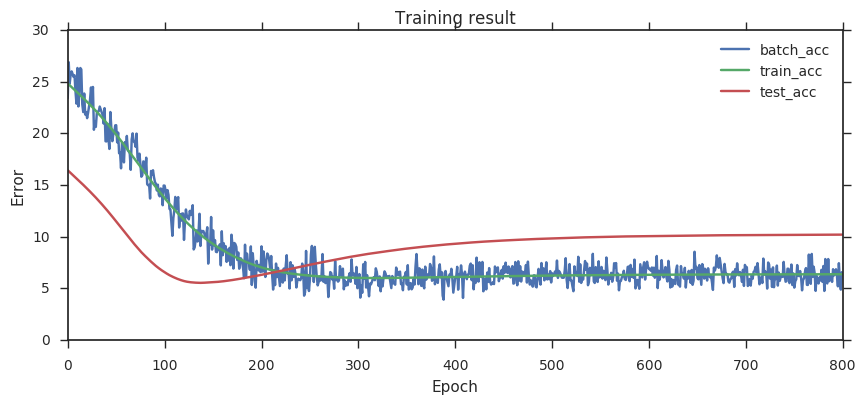

In [24]:
df = pd.DataFrame(data=results, columns = ["epoch", "batch_acc", "train_acc", "test_acc"])
df.set_index("epoch", drop=True, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
 
ax.plot(df)
ax.set(xlabel='Epoch',
       ylabel='Error',
       title='Training result')
 
ax.legend(df.columns, loc=1)

print "Minimum test loss:", np.min(df["test_acc"])